In [1]:
import os
import sys
import shutil
import random
import glob
import multiprocessing
import socket
import pickle
import importlib
import itertools
import functools
import collections
import logging
logging.basicConfig(level=logging.INFO)

import tqdm

import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('ggplot')
import seaborn as sns

from statsmodels.stats.multitest import multipletests

from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

if sys.platform == 'darwin':
    SRC_DIR = "/Users/kevin/Documents/Stanford/zou/chang_rna_localization/rnafinder/rnafinder"
else:
    if socket.gethostname() == "changrila2.stanford.edu":
        SRC_DIR = "/storage/wukevin/projects/rnafinder/rnafinder"
    else:
        SRC_DIR = "/oak/stanford/groups/jamesz/wukevin/chang_rna_localization/rnafinder/rnafinder"
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import data_loader
import model_utils
import plotting_utils
import kmer
import pwm
import fasta
import interpretation

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots")
assert os.path.isdir(PLOT_DIR)

INTERMEDIATE_DATA_DIR = os.path.join(os.path.dirname(SRC_DIR), "data", "intermediate")
assert os.path.isdir(INTERMEDIATE_DATA_DIR)

np.random.seed(27492)
SEED = 27492

INFO:root:CPU


In [2]:
K_FOLD = 5

In [3]:
importlib.reload(data_loader)
train_dataset = data_loader.LocalizationClassificationKmers("train", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], trans_parts=['intron'], addtl_negatives=False, fasta_table=os.path.join(data_loader.LOCAL_DATA_DIR, "parsed_fasta_rel90_with_intron_tss.txt.gz"))
valid_dataset = data_loader.LocalizationClassificationKmers("valid", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], trans_parts=['intron'], addtl_negatives=False, fasta_table=os.path.join(data_loader.LOCAL_DATA_DIR, "parsed_fasta_rel90_with_intron_tss.txt.gz"))
test_dataset = data_loader.LocalizationClassificationKmers("test", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], trans_parts=['intron'], addtl_negatives=False, fasta_table=os.path.join(data_loader.LOCAL_DATA_DIR, "parsed_fasta_rel90_with_intron_tss.txt.gz"))

INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 986/2928 = 0.33674863387978143 positive
INFO:root:Lma - 614/2928 = 0.20969945355191258 positive
INFO:root:Mito - 244/2928 = 0.08333333333333333 positive
INFO:root:Nes - 162/2928 = 0.055327868852459015 positive
INFO:root:Nik - 1094/2928 = 0.37363387978142076 positive
INFO:root:Nls - 659/2928 = 0.22506830601092895 positive
INFO:root:NucPore - 129/2928 = 0.04405737704918033 positive
INFO:root:Omm - 582/2928 = 0.1987704918032787 positive
INFO:root:2597	0.8869535519125683	protein_coding
INFO:root:77	0.026297814207650275	lincRNA
INFO:root:77	0.026297814207650275	antisense_RNA
INFO:root:40	0.01366120218579235	processed_pseudogene
INFO:root:36	0.012295081967213115	transcribed_unprocessed_pseudogene
INFO:root:24	0.00819672131147541	processed_transcript


In [4]:
train_data = data_loader.load_data_as_np(train_dataset, ignore_missing=True)
valid_data = data_loader.load_data_as_np(valid_dataset, ignore_missing=True)
test_data = data_loader.load_data_as_np(test_dataset, ignore_missing=True)

100%|██████████| 366/366 [00:08<00:00, 43.73it/s]


In [5]:
# Random forest classifier
rf_kwargs = {
    "n_estimators": 250,
    "n_jobs": 12,
}

rf_model, rf_per_class_perf, rf_overall_perf = model_utils.multi_train(
    RandomForestClassifier(**rf_kwargs),
    train_data,
    valid_data,
    verbose=False
)
print("Validation AUROC: {}".format(rf_overall_perf.auroc))
print("Validation AUPRC: {}".format(rf_overall_perf.auprc))

Validation AUROC: 0.6398703911309211
Validation AUPRC: 0.2851504883519503


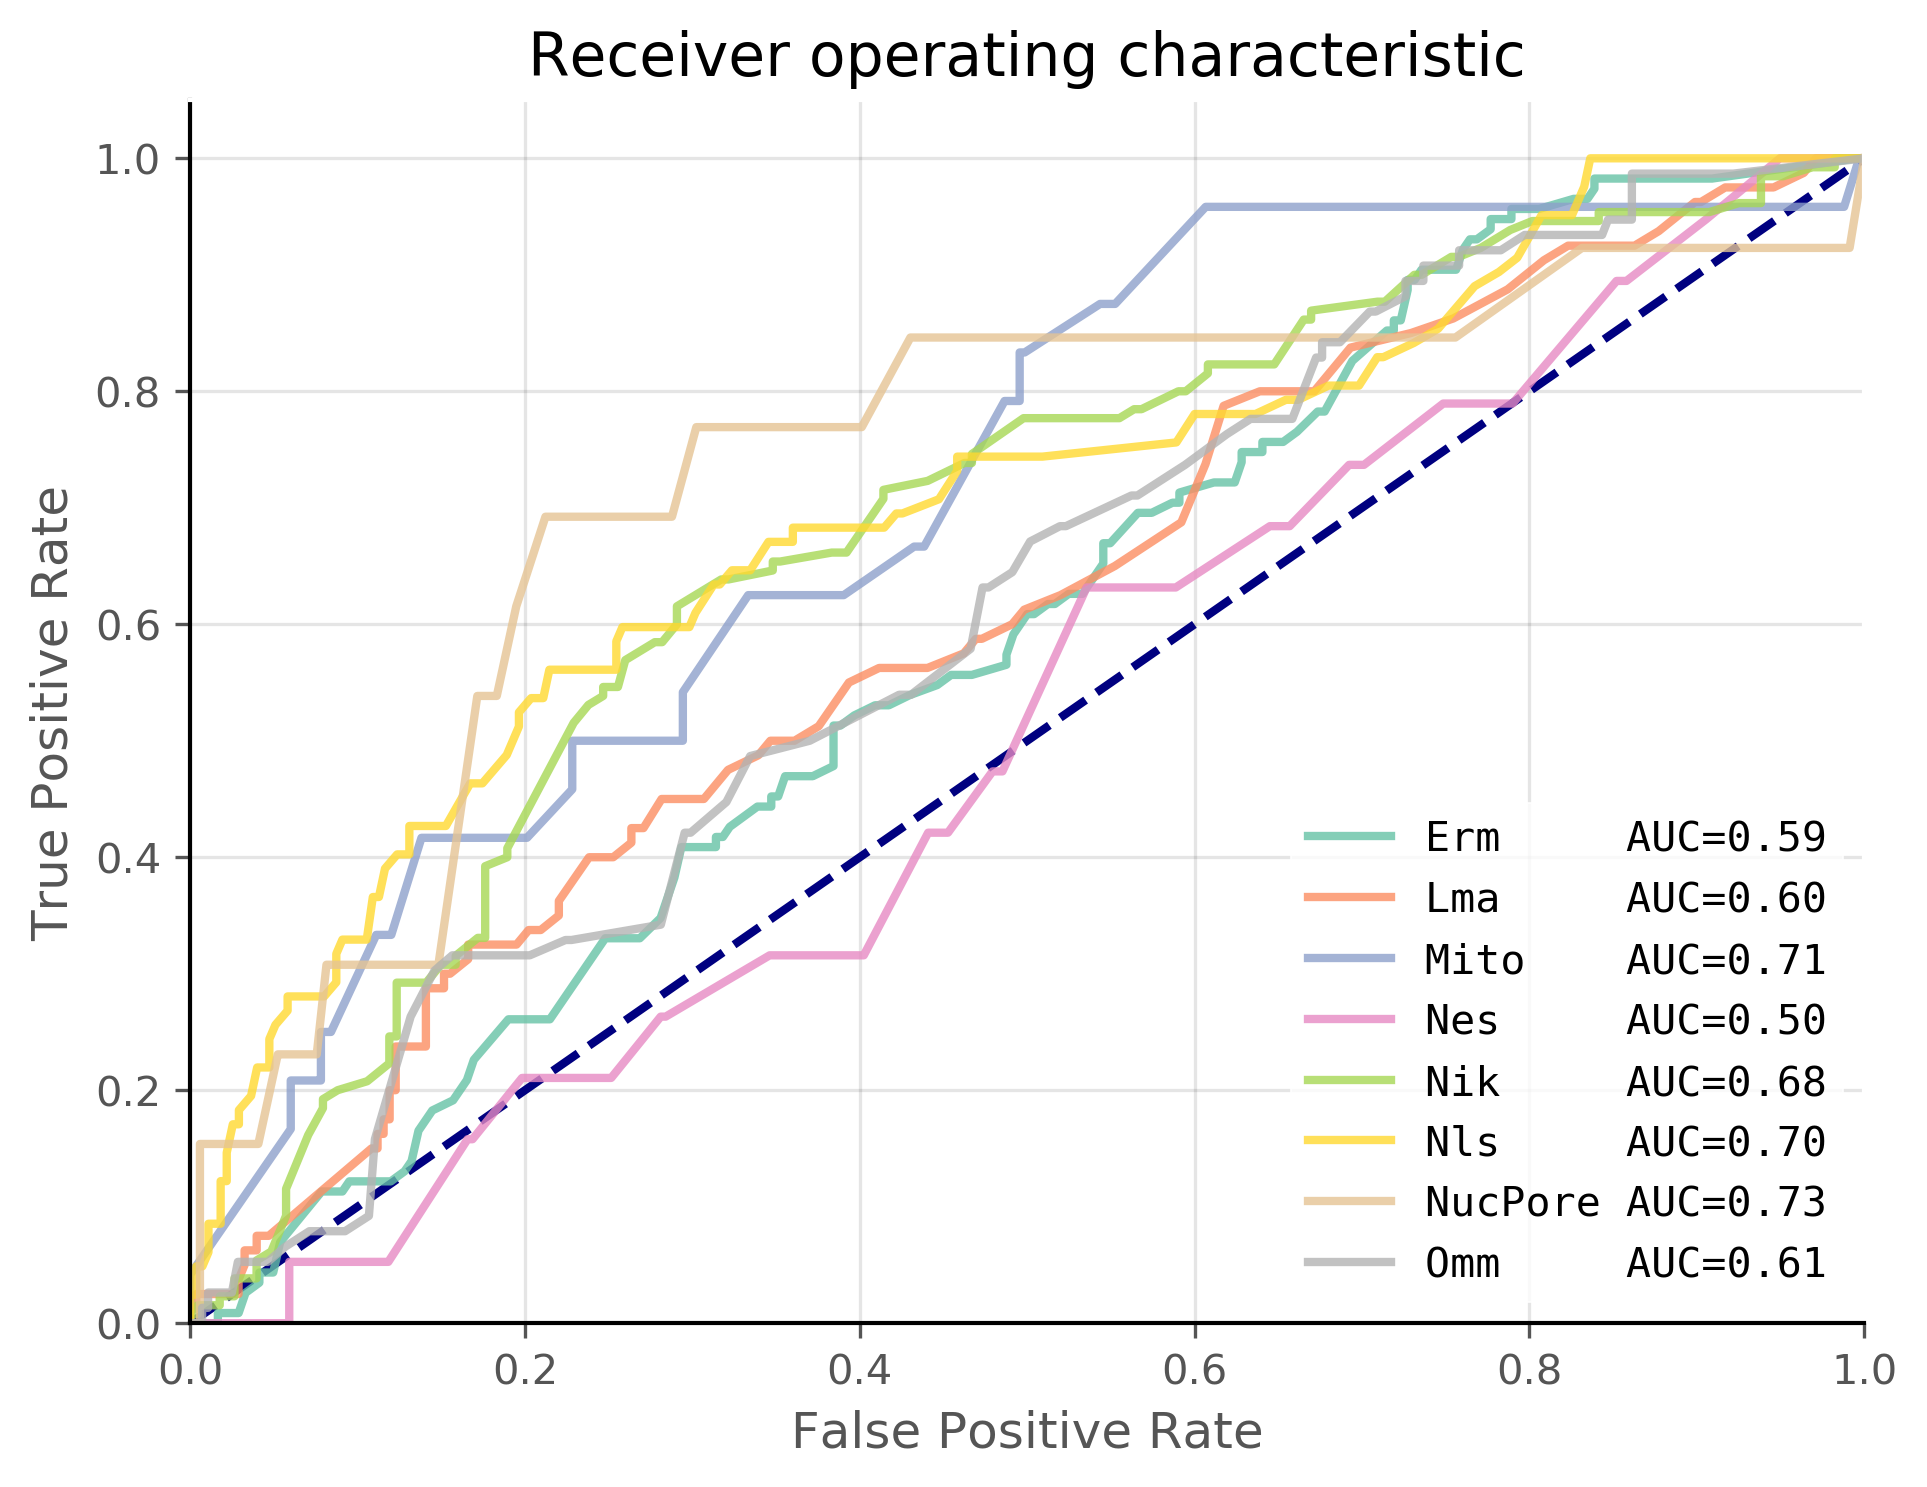

In [6]:
importlib.reload(plotting_utils)
plotting_utils.plot_auroc(
    {localization: perf for localization, perf in zip(train_dataset.compartments, rf_per_class_perf)}
)

## Hyperparameter search for RF

In [7]:
importlib.reload(model_utils)

rf_n_estimators = [100, 150, 200, 250, 300]
rf_criterion = ["gini", "entropy"]
rf_max_depth = [None, 25, 50, 100]
rf_min_samples_leaf = [0.001, 0.01, 0.1, 1]
rf_max_features = ["sqrt", "log2"]
rf_class_weight = ['balanced', None]

param_combos = list(itertools.product(
    rf_n_estimators,
    rf_criterion,
    rf_max_depth,
    rf_min_samples_leaf,
    rf_max_features,
    rf_class_weight,
))

param_combos_overall_perf = []
param_combos_class_perf = []
param_combos_models = []
for arg_combo in tqdm.tqdm_notebook(param_combos):
    n_est, crit, depth, min_samp, max_feat, weight = arg_combo
    rf_param_dict = {
        "n_estimators": n_est,
        "criterion": crit,
        "max_depth": depth,
        "min_samples_leaf": min_samp,
        "max_features": max_feat,
        "class_weight": weight,
        "n_jobs": 32,
        "random_state": 39282,
    }
    rf_model, rf_per_class_perf, rf_overall_perf = model_utils.multi_train(
        RandomForestClassifier(**rf_param_dict),
        train_data,
        valid_data,
        verbose=False
    )
    param_combos_models.append(rf_model)
    param_combos_overall_perf.append(rf_overall_perf)
    param_combos_class_perf.append(rf_per_class_perf)

In [8]:
auroc_values = [p.auroc for p in param_combos_overall_perf]
print(max(auroc_values), param_combos[np.argmax(auroc_values)])
auprc_values = [p.auprc for p in param_combos_overall_perf]
print(max(auprc_values), param_combos[np.argmax(auprc_values)])

0.6541658808293012 (200, 'gini', None, 0.01, 'sqrt', None)
0.2912638138566813 (200, 'gini', None, 0.001, 'sqrt', None)


In [9]:
# Copied from above
rf_optimal_params = (200, 'gini', 25, 1, 'sqrt', None)

{'n_estimators': 200, 'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'class_weight': None, 'n_jobs': 24, 'random_state': 39282}
Validation AUROC: 0.6472098994024834
Validation AUPRC: 0.27285866616734833


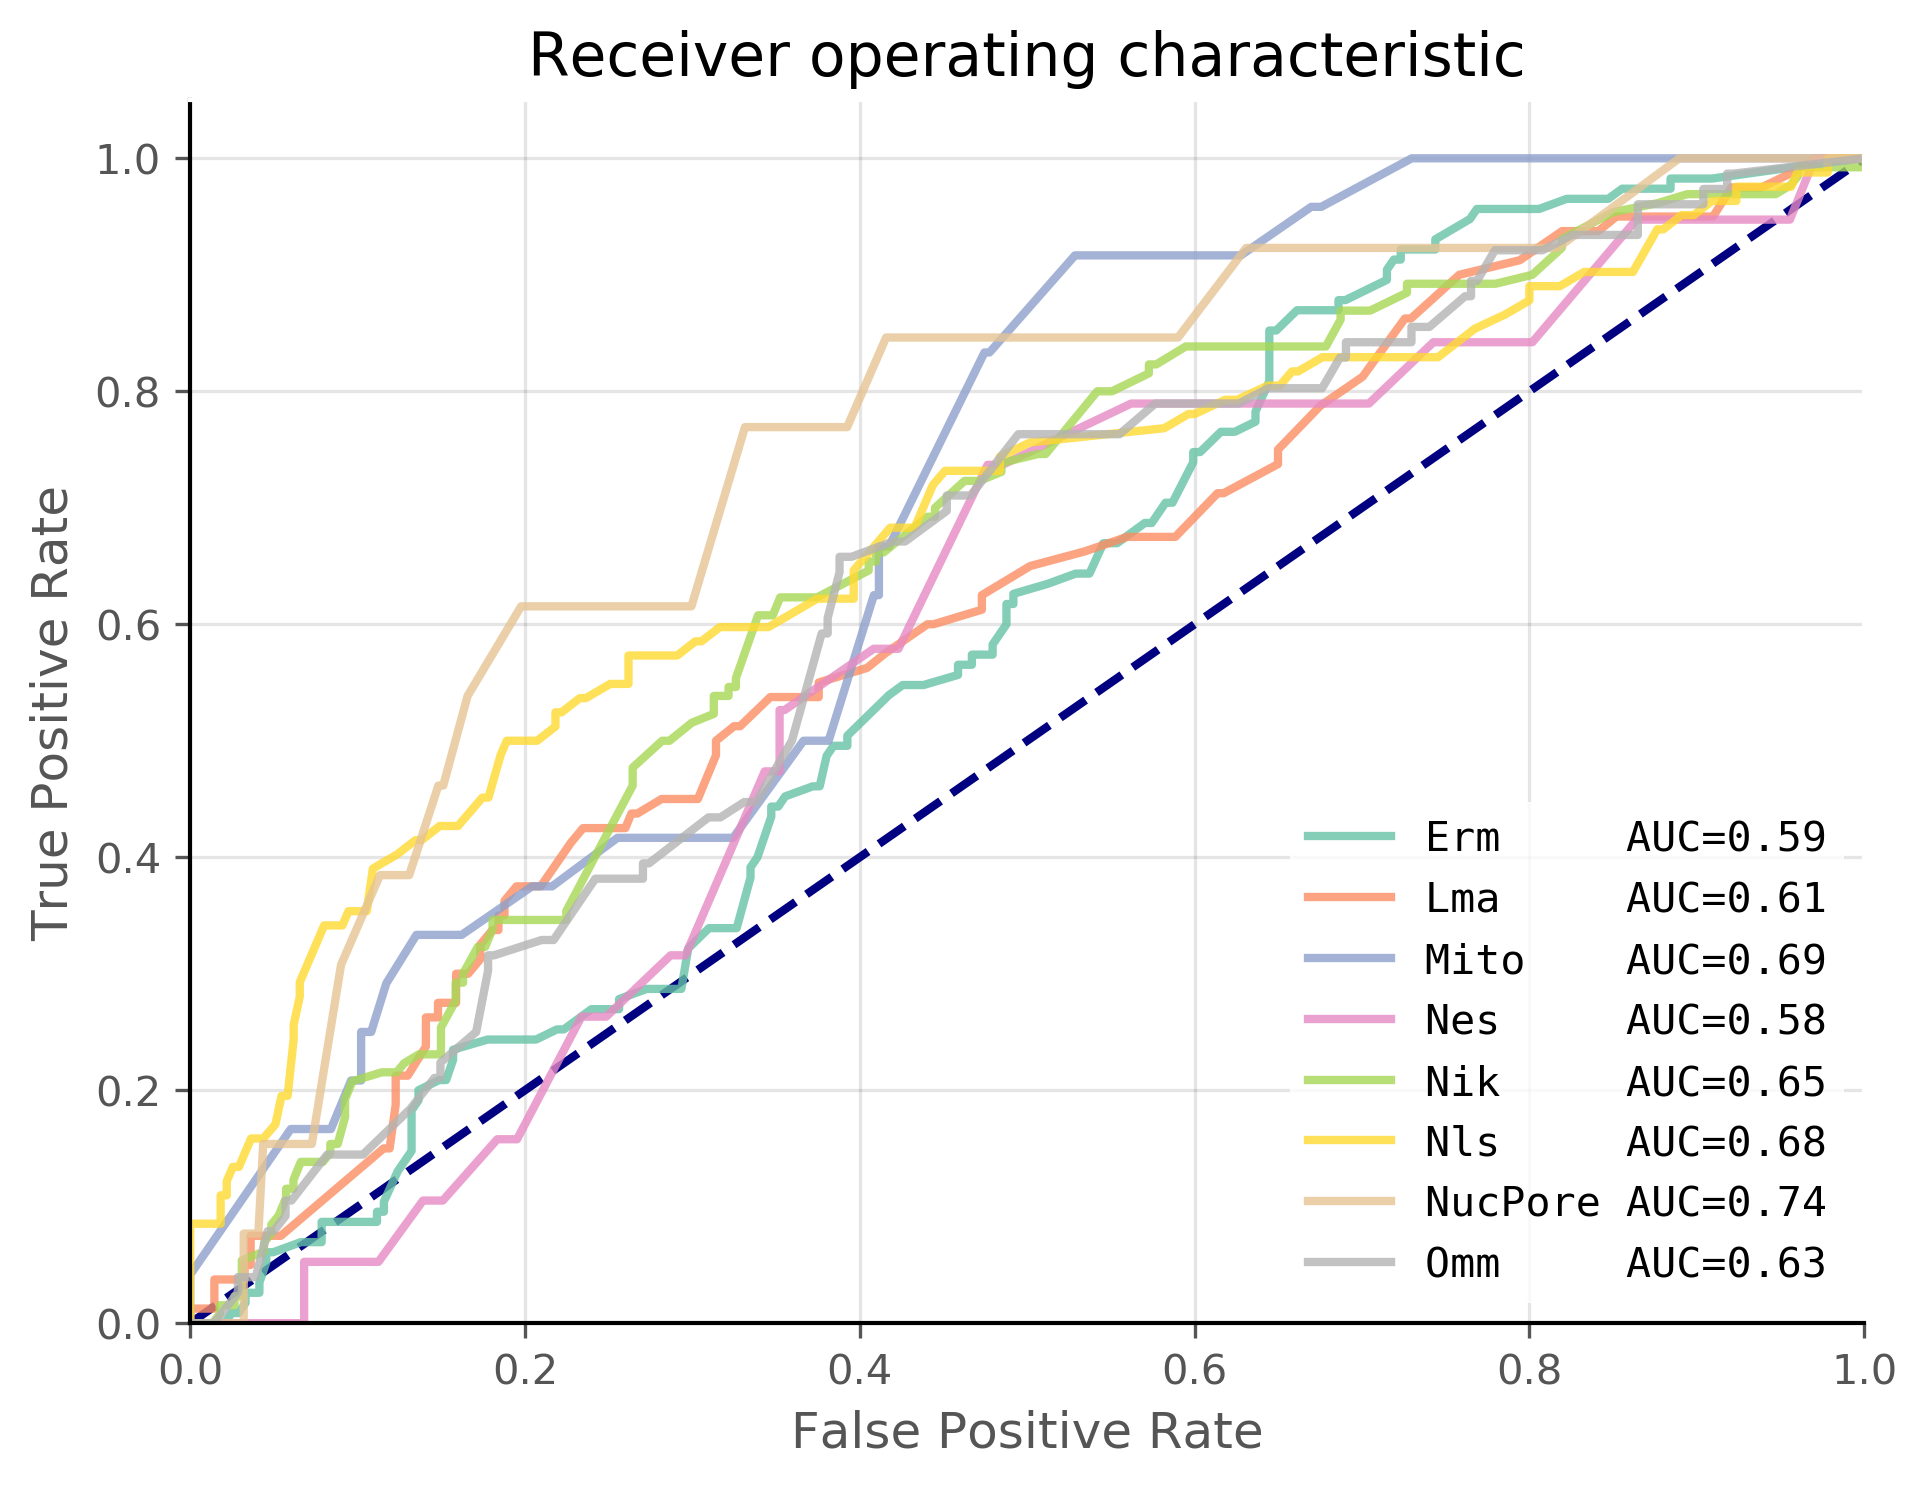

In [10]:
# rf_optimal_index = np.argmax(auroc_values)
# rf_optimal_model = param_combos_models[rf_optimal_index]
# rf_optimal_class_perf = param_combos_class_perf[rf_optimal_index]
# rf_optimal_perf = param_combos_overall_perf[rf_optimal_index]
# rf_optimal_params = param_combos[rf_optimal_index]

rf_optimal_param_dict = {
    "n_estimators": rf_optimal_params[0],
    "criterion": rf_optimal_params[1],
    "max_depth": rf_optimal_params[2],
    "min_samples_leaf": rf_optimal_params[3],
    "max_features": rf_optimal_params[4],
    "class_weight": rf_optimal_params[5],
    "n_jobs": 24,
    "random_state": 39282,
}
print(rf_optimal_param_dict)

rf_optimal_model, rf_optimal_class_perf, rf_optimal_perf = model_utils.multi_train(
    RandomForestClassifier(**rf_optimal_param_dict),
    train_data,
    valid_data,
    verbose=False
)

print("Validation AUROC: {}".format(rf_optimal_perf.auroc))
# print("Validation AUROC var: {}".format(np.var([p.auroc for p in rf_optimal_class_perf])))
print("Validation AUPRC: {}".format(rf_optimal_perf.auprc))
# print("Validation AUPRC var: {}".format(np.var([p.auprc for p in rf_optimal_class_perf])))
importlib.reload(plotting_utils)
plotting_utils.plot_auroc(
    {localization: perf for localization, perf in zip(train_dataset.compartments, rf_optimal_class_perf)}
)

In [11]:
# Same, but for test set
rf_optimal_class_perf_test = []
for i in range(len(test_dataset.compartments)):
    rf_optimal_class_perf_test.append(model_utils.generate_model_perf(
        test_data[1][:, i].flatten(),
        model_utils.list_preds_to_array_preds(rf_optimal_model.predict_proba(test_data[0]))[:, i].flatten(),
        multiclass=False,
    ))
rf_optimal_perf_test = model_utils.generate_model_perf(
    test_data[1],
    model_utils.list_preds_to_array_preds(rf_optimal_model.predict_proba(test_data[0])),
    multiclass=True,
)

Intron model test set AUROC: 0.6560436836059573
Intron model test set AUPRC: 0.27857663489502255


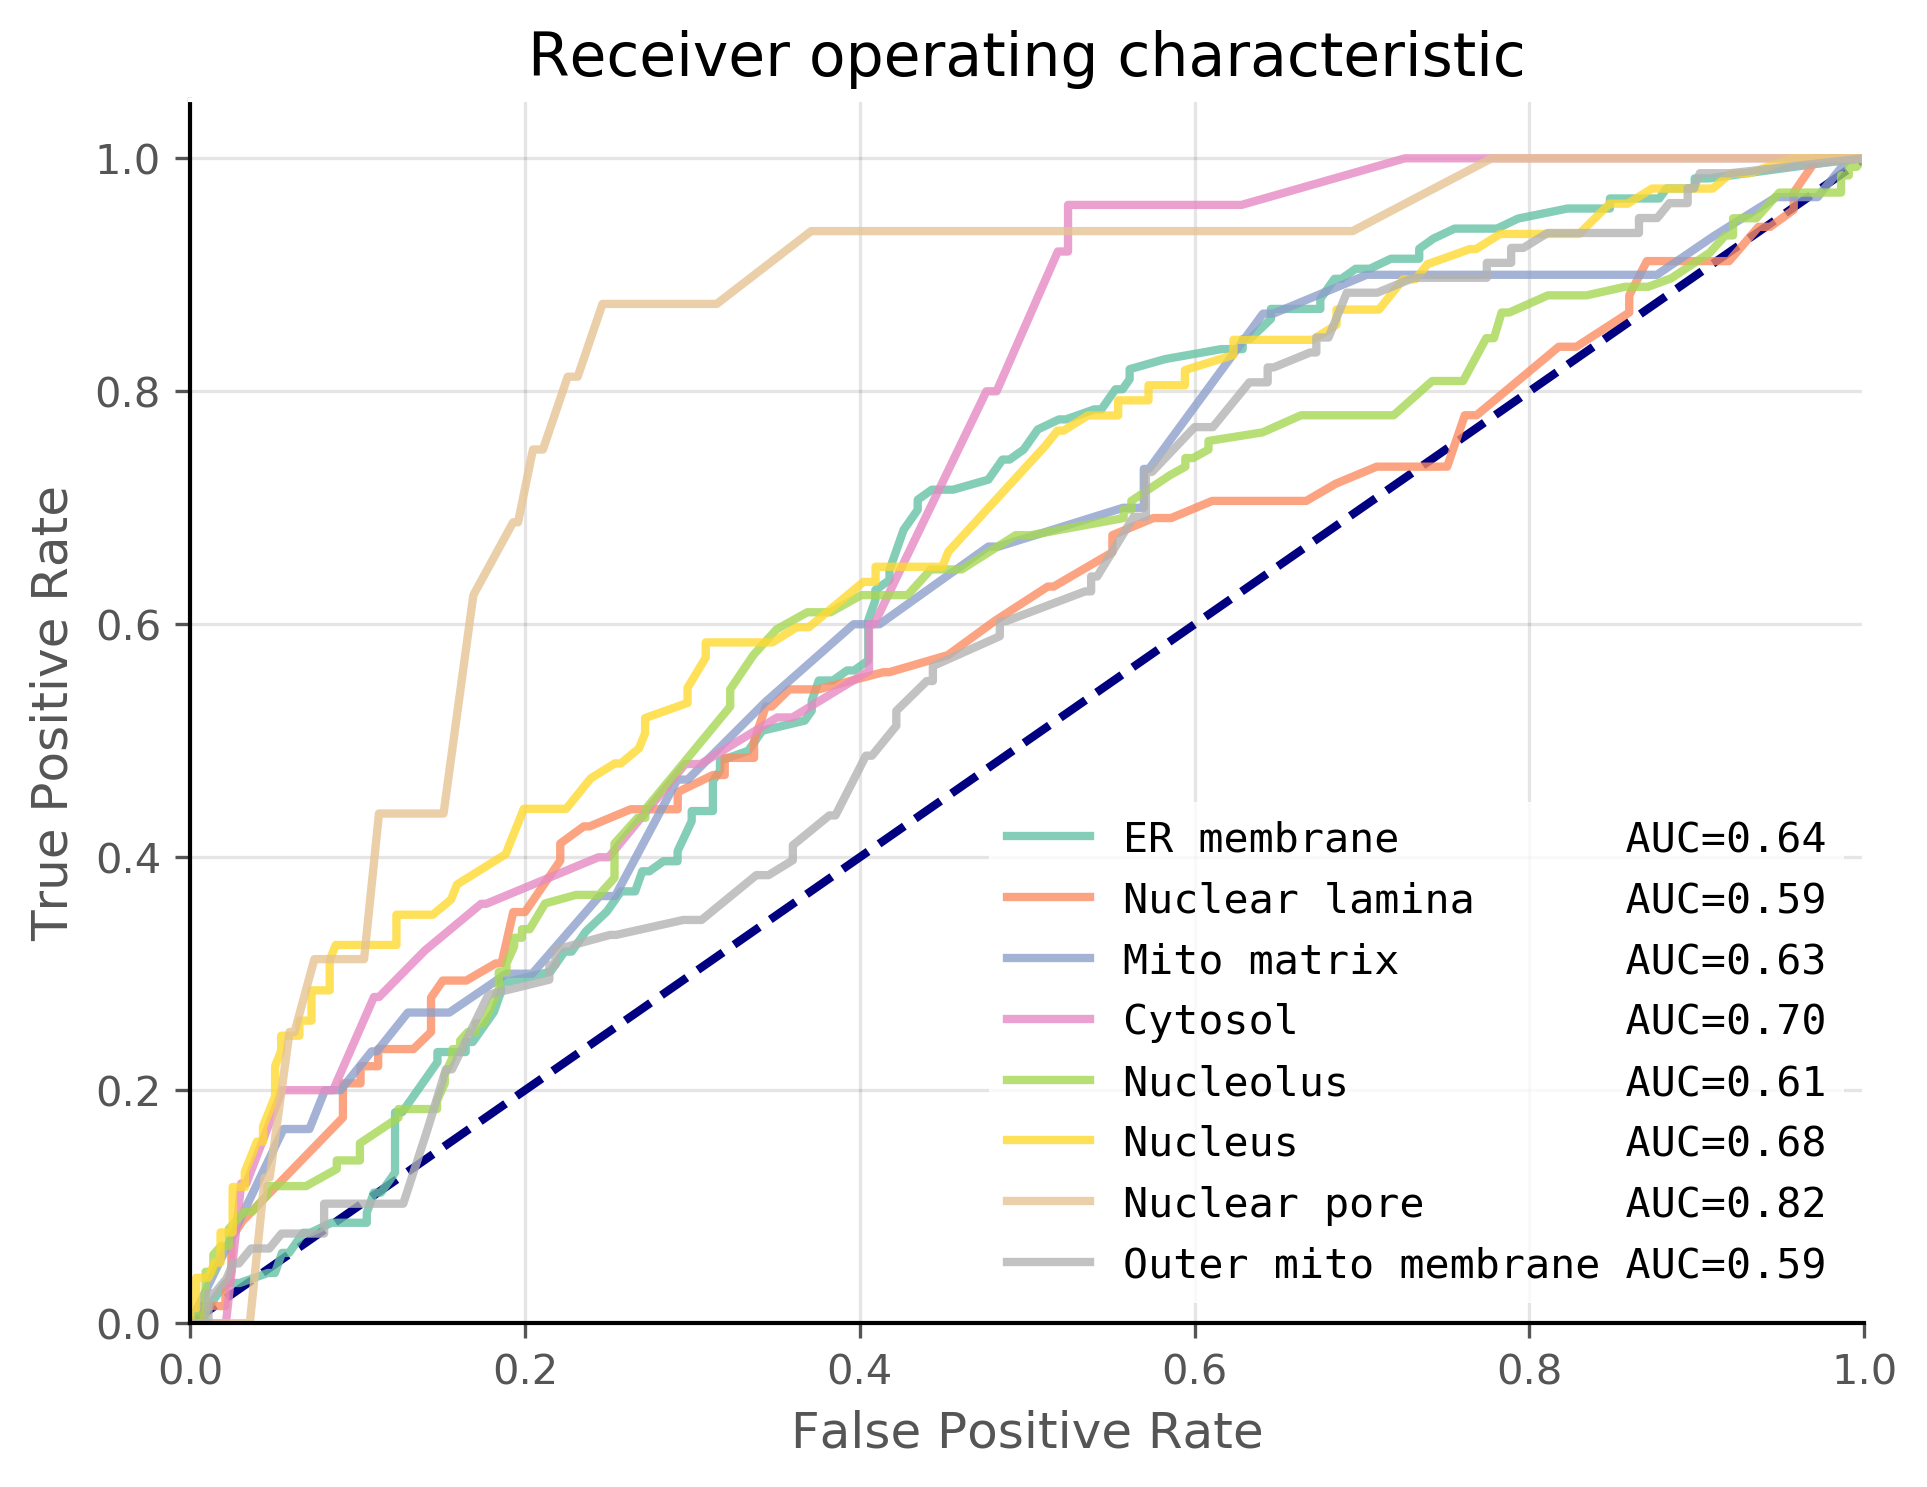

In [12]:
importlib.reload(plotting_utils)
print(f"Intron model test set AUROC: {rf_optimal_perf_test.auroc}")
print(f"Intron model test set AUPRC: {rf_optimal_perf_test.auprc}")

plotting_utils.plot_auroc(
    {data_loader.LOCALIZATION_FULL_NAME_DICT[localization]: perf for localization, perf in zip(test_dataset.compartments, rf_optimal_class_perf_test)}
)

## Model with both introns and exons

In [13]:
importlib.reload(data_loader)
# Use the full_prefix to denote that this is the full u5 cds u3 intron model
full_train_dataset = data_loader.LocalizationClassificationKmers("train", kmer_sizes=[3, 4, 5], trans_parts=['u5', 'cds', 'u3', 'intron'], addtl_negatives=False, fasta_table=os.path.join(data_loader.LOCAL_DATA_DIR, "parsed_fasta_rel90_with_intron_tss.txt.gz"))
full_valid_dataset = data_loader.LocalizationClassificationKmers("valid", kmer_sizes=[3, 4, 5], trans_parts=['u5', 'cds', 'u3', 'intron'], addtl_negatives=False, fasta_table=os.path.join(data_loader.LOCAL_DATA_DIR, "parsed_fasta_rel90_with_intron_tss.txt.gz"))
full_test_dataset = data_loader.LocalizationClassificationKmers("test", kmer_sizes=[3, 4, 5], trans_parts=['u5', 'cds', 'u3', 'intron'], addtl_negatives=False, fasta_table=os.path.join(data_loader.LOCAL_DATA_DIR, "parsed_fasta_rel90_with_intron_tss.txt.gz"))

INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 983/2928 = 0.335724043715847 positive
INFO:root:Lma - 617/2928 = 0.210724043715847 positive
INFO:root:Mito - 229/2928 = 0.0782103825136612 positive
INFO:root:Nes - 167/2928 = 0.05703551912568306 positive
INFO:root:Nik - 1107/2928 = 0.3780737704918033 positive
INFO:root:Nls - 655/2928 = 0.22370218579234974 positive
INFO:root:NucPore - 132/2928 = 0.045081967213114756 positive
INFO:root:Omm - 585/2928 = 0.19979508196721313 positive
INFO:root:2605	0.8896857923497268	protein_coding
INFO:root:81	0.027663934426229508	antisense_RNA
INFO:root:77	0.026297814207650275	lincRNA
INFO:root:37	0.012636612021857924	transcribed_unprocessed_pseudogene
INFO:root:35	0.011953551912568305	processed_pseudogene
INFO:root:24	0.00819672131147541	processed_transcript
INFO

In [14]:
full_train_data = data_loader.load_data_as_np(full_train_dataset, ignore_missing=True)
full_valid_data = data_loader.load_data_as_np(full_valid_dataset, ignore_missing=True)
full_test_data = data_loader.load_data_as_np(full_test_dataset, ignore_missing=True)

100%|██████████| 366/366 [00:12<00:00, 28.76it/s]


In [15]:
full_train_data[0].shape

(2817, 5376)

In [16]:
full_param_combos_overall_perf = []
full_param_combos_class_perf = []
full_param_combos_models = []
for arg_combo in tqdm.tqdm_notebook(param_combos):
    n_est, crit, depth, min_samp, max_feat, weight = arg_combo
    rf_param_dict = {
        "n_estimators": n_est,
        "criterion": crit,
        "max_depth": depth,
        "min_samples_leaf": min_samp,
        "max_features": max_feat,
        "class_weight": weight,
        "n_jobs": 32,
        "random_state": 39282,
    }
    rf_model, rf_per_class_perf, rf_overall_perf = model_utils.multi_train(
        RandomForestClassifier(**rf_param_dict),
        train_data,
        valid_data,
        verbose=False
    )
    full_param_combos_models.append(rf_model)
    full_param_combos_overall_perf.append(rf_overall_perf)
    full_param_combos_class_perf.append(rf_per_class_perf)

The model with added introns doesn't do well compared to without introns

In [17]:
full_auroc_values = [p.auroc for p in param_combos_overall_perf]
print(max(full_auroc_values), param_combos[np.argmax(full_auroc_values)])
full_auprc_values = [p.auprc for p in param_combos_overall_perf]
print(max(full_auprc_values), param_combos[np.argmax(full_auprc_values)])

0.6541658808293012 (200, 'gini', None, 0.01, 'sqrt', None)
0.2912638138566813 (200, 'gini', None, 0.001, 'sqrt', None)
